## 必要なライブラリのインポートとデータの読み込み

In [1]:
from typing import Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
url = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/AusAntidiabeticDrug.csv'
df = pd.read_csv(url, index_col='ds', parse_dates=True)

## 時系列とその成分を可視化する

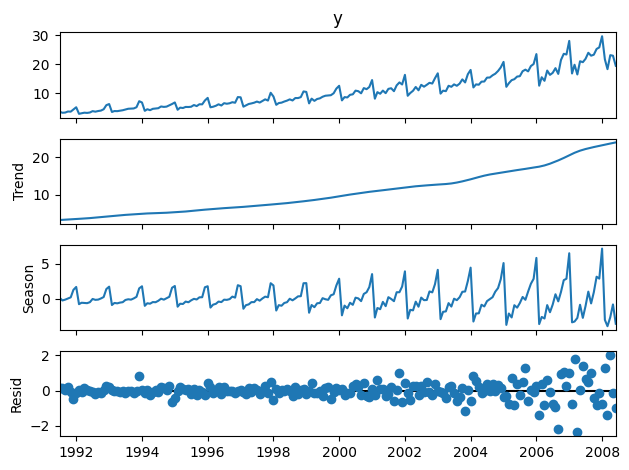

In [9]:
decomposition = STL(df['y'], period=12).fit()
decomposition.plot()
plt.tight_layout()

## データをモデル化する

In [15]:
# 一意なSARIMA(p,q)モデルをすべて適合させる関数
def optimize_SARIMA(endog: Union[pd.Series, list], orders: list, d: int, D: int, s: int) -> pd.DataFrame:
    """
    endog: 時系列データ
    orders: ARIMA(p, d, q)のpとqの値の組み合わせ
    d: 和分次数
    D: 季節差分の次数
    s: 頻度
    """
    res = []
    for order in tqdm(orders):
        try:
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s), 
                simple_differencing=False
            ).fit(disp=False)
            res.append([order, model.aic])
        except:
            continue
    df_res = (
        pd.DataFrame(res, columns=['(p,q,P,Q)', 'AIC'])
        .sort_values(by='AIC', ascending=True)
        .reset_index(drop=True)
    )
    return df_res 

In [11]:
# 定常性の確認
ADF_result = adfuller(df['y'])
print(f'処方数(0次差分)ADF検定')
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')
ADF_result = adfuller(np.diff(df['y']))
print(f'処方数(1次差分)ADF検定')
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')
# 季節差分を使うとm=12
ADF_result = adfuller(np.diff(np.diff(df['y']), n=12))
print(f'処方数(1次差分、季節1次差分)ADF検定')
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

処方数(0次差分)ADF検定
ADF Statistic: 3.145
p-value: 1.000
処方数(1次差分)ADF検定
ADF Statistic: -2.495
p-value: 0.117
処方数(1次差分、季節1次差分)ADF検定
ADF Statistic: -19.848
p-value: 0.000


In [17]:
# d=1, D=1, s=12で良いことがわかる
d=1
D=1
s=12
# dfをtrain, testに分ける
train = df[:168]
test = df[168:]
# 最適なパラメーターを探索する
# p,q,P,Qを0~4まで動かす
orders = list(product(range(5), repeat=4))
# 探索
optimize_SARIMA(train, orders, d, D, s)

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(2, 4, 1, 3)",271.219926
2,"(3, 3, 1, 3)",271.406306
3,"(4, 1, 1, 3)",272.145292
4,"(0, 4, 1, 3)",272.152379
...,...,...
620,"(0, 0, 0, 4)",351.680917
621,"(0, 0, 2, 4)",353.250982
622,"(0, 0, 0, 1)",354.751719
623,"(0, 0, 1, 0)",357.173706


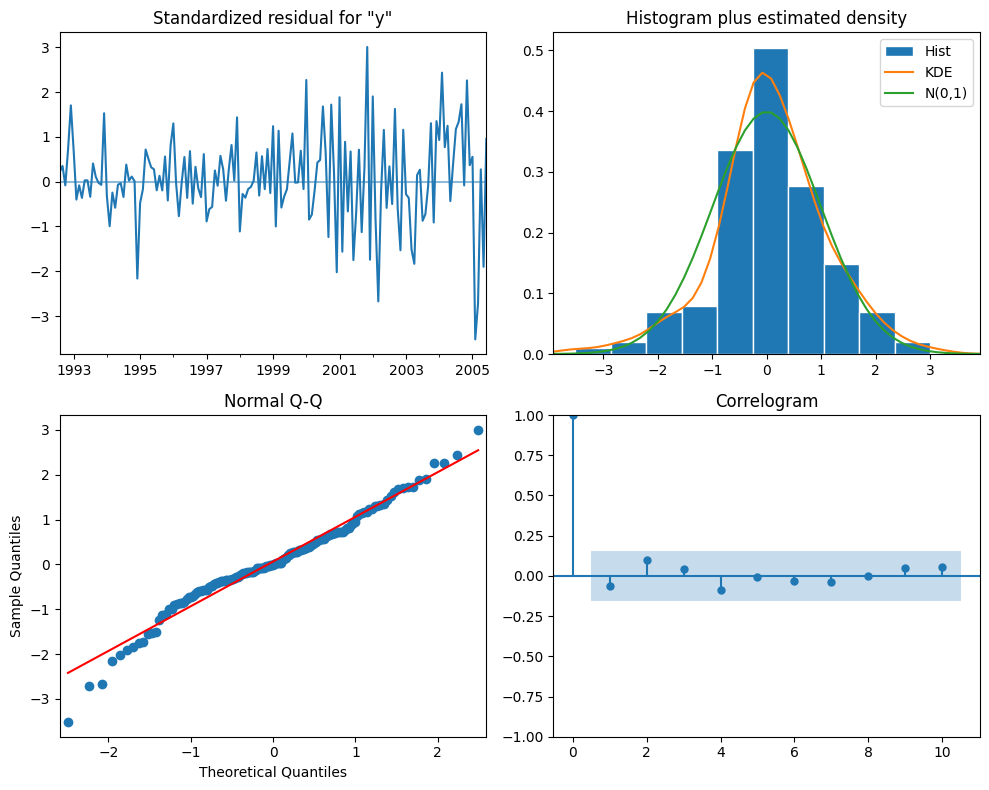

In [20]:
# テキストは最適なのはp=2,q=3,P=1,Q=3と言っている
# が、訳注にあるように手元で確認してみるとp=3,q=1,P=1,Q=3が最適となる
# ひとまずテキストに合わせよう
model = SARIMAX(train, order=(2,d,3), seasonal_order=(1,D,3,s), simple_differencing=False).fit(disp=False)

model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

In [22]:
# 残差分析
# すべて0.05を超えているの問題なく次に進む
acorr_ljungbox(model.resid, np.arange(1, 11))

,lb_stat,lb_pvalue
1,1.434320,0.231061
2,1.697549,0.427939
3,2.266920,0.518888
4,3.808044,0.432607
5,4.352727,0.499826
6,4.369483,0.626808
7,9.175681,0.240288
8,9.239538,0.322494
9,9.422606,0.399213
10,9.422607,0.492520


## モデルによる予測値の生成と性能の評価

In [33]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    preds = []
    
    if method == 'last_season':
        for i in range(train_len, total_len, window):
            preds.extend(df['y'][i-window:i].values)
        return preds
    elif method == 'SARIMA':
        for i in range(train_len, total_len, window):
            model = SARIMAX(
                df['y'][:i],
                order=(2,d,3),
                seasonal_order=(1,D,3,s),
                simple_differencing=False
            ).fit(disp=False)
            pred = model.forecast(window)
            preds.extend(pred.values)
        return preds
    else:
        raise ValueError('method must be "last_season" or "SARIMA".')

In [34]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 12
methods = ['last_season', 'SARIMA']
for method in methods:
    test[method] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, method)

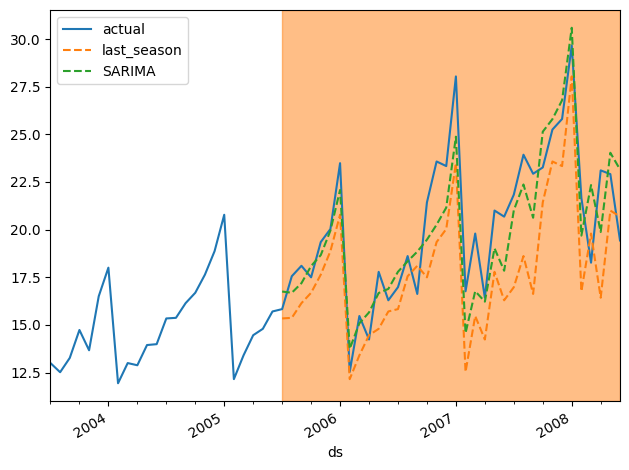

In [43]:
fig, ax = plt.subplots()
df['y'][-60:].plot(ax=ax, label='actual')
ax.axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
for method in methods:
    test[method].plot(ax=ax, label=method, ls='dashed')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()

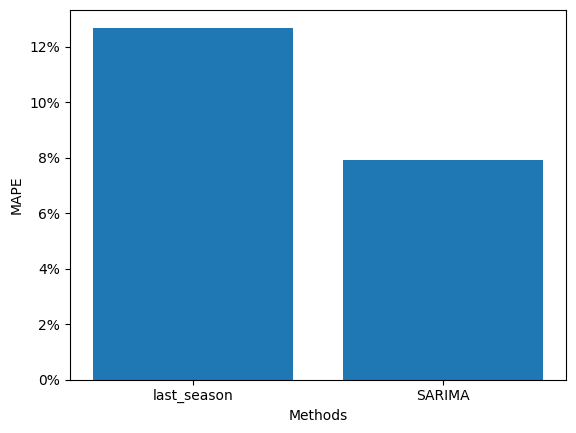

In [44]:
# mapeを使って性能比較
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

plt.xlabel('Methods')
plt.ylabel('MAPE')
plt.bar(
    methods,
    [mape(test['y'], test[method]) for method in methods]
)
plt.gca().yaxis.set_major_formatter(lambda y, _: '{:.0%}'.format(y))
plt.show()